**Prepare the data**

In [1]:
from Utility.utilities import  load_train_data
import os

dataset = 'DLPFC'
id = '151509'
pixel_size = 16
img_path = os.path.join('./Img_encoder/models/', dataset, id, 'img_emb.npy')
data_path = './Data'
knn = 7

edge_index, fea, G, G_neg, gt, adata = load_train_data(id=id, 
                                                       knn=knn, 
                                                       data_path=os.path.join(data_path, dataset), 
                                                       img_path=img_path, 
                                                       margin=pixel_size, 
                                                       dataset=dataset, 
                                                       return_adata=True)

**Train the model**

In [2]:
from Utility.train_w_data import train_
import yaml

cfg_path = './Best_cfg'
with open(os.path.join(cfg_path, dataset, id+'.yaml'), 'r') as f:
    cfg = yaml.safe_load(f)

ari, label_pred, emb, recon = train_(edge_index, fea, G, G_neg, gt, cfg)

print(f'The final ARI is {ari}')

Training:  11%|█         | 224/2000 [00:11<01:33, 19.04it/s]

Reached the tolerance, early stop training at epoch 224
The final ARI is 0.6847448790101671


**Visualize the results**

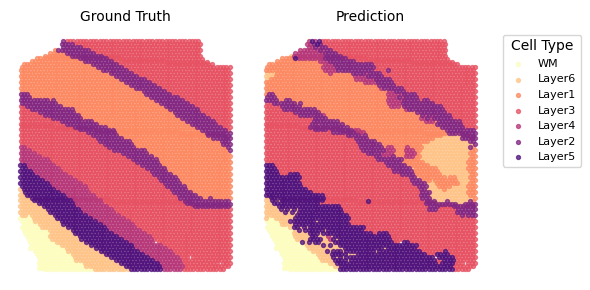

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from Utility.utilities import hungarian_match
label_pred = hungarian_match(gt, label_pred)
label_dict = dict(zip(adata.obsm['label_dict'].values, adata.obs['Ground Truth'].values))

cmap = 'magma'
c_list = plt.get_cmap(cmap)(np.linspace(0, 1, 9))[::-1]
loc = adata.obsm['spatial'] * np.array([1, -1])

fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=100)
for k, label in enumerate(set(gt)):
    ax[0].scatter(loc[gt==label, 0], loc[gt==label, 1], color=c_list[k], s=8, alpha=0.75, label=label_dict[k])
    ax[1].scatter(loc[label_pred==label, 0], loc[label_pred==label, 1], color=c_list[k], s=8, alpha=0.75, label=label_dict[k])
    
for axis in ax:
    for sp in axis.spines.values():
        sp.set_visible(False)
    axis.set_xticks([])
    axis.set_yticks([])
ax[0].set_title('Ground Truth', fontsize=10)
ax[1].set_title('Prediction', fontsize=10)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, title='Cell Type', title_fontsize=10)
plt.tight_layout()
plt.show()

In [4]:
id = '151673'
img_path = os.path.join('./Img_encoder/models/', dataset, id, 'img_emb.npy')
edge_index, fea, G, G_neg, gt, adata = load_train_data(id=id, 
                                                       knn=knn, 
                                                       data_path=os.path.join(data_path, dataset), 
                                                       img_path=img_path, 
                                                       margin=pixel_size, 
                                                       dataset=dataset, 
                                                       return_adata=True)
cfg_path = './Best_cfg'
with open(os.path.join(cfg_path, dataset, id+'.yaml'), 'r') as f:
    cfg = yaml.safe_load(f)

ari, label_pred, emb, recon = train_(edge_index, fea, G, G_neg, gt, cfg)

print(f'The final ARI is {ari}')

Training:  29%|██▉       | 575/2000 [00:22<00:54, 26.11it/s]

Reached the tolerance, early stop training at epoch 575
The final ARI is 0.6401756503930481


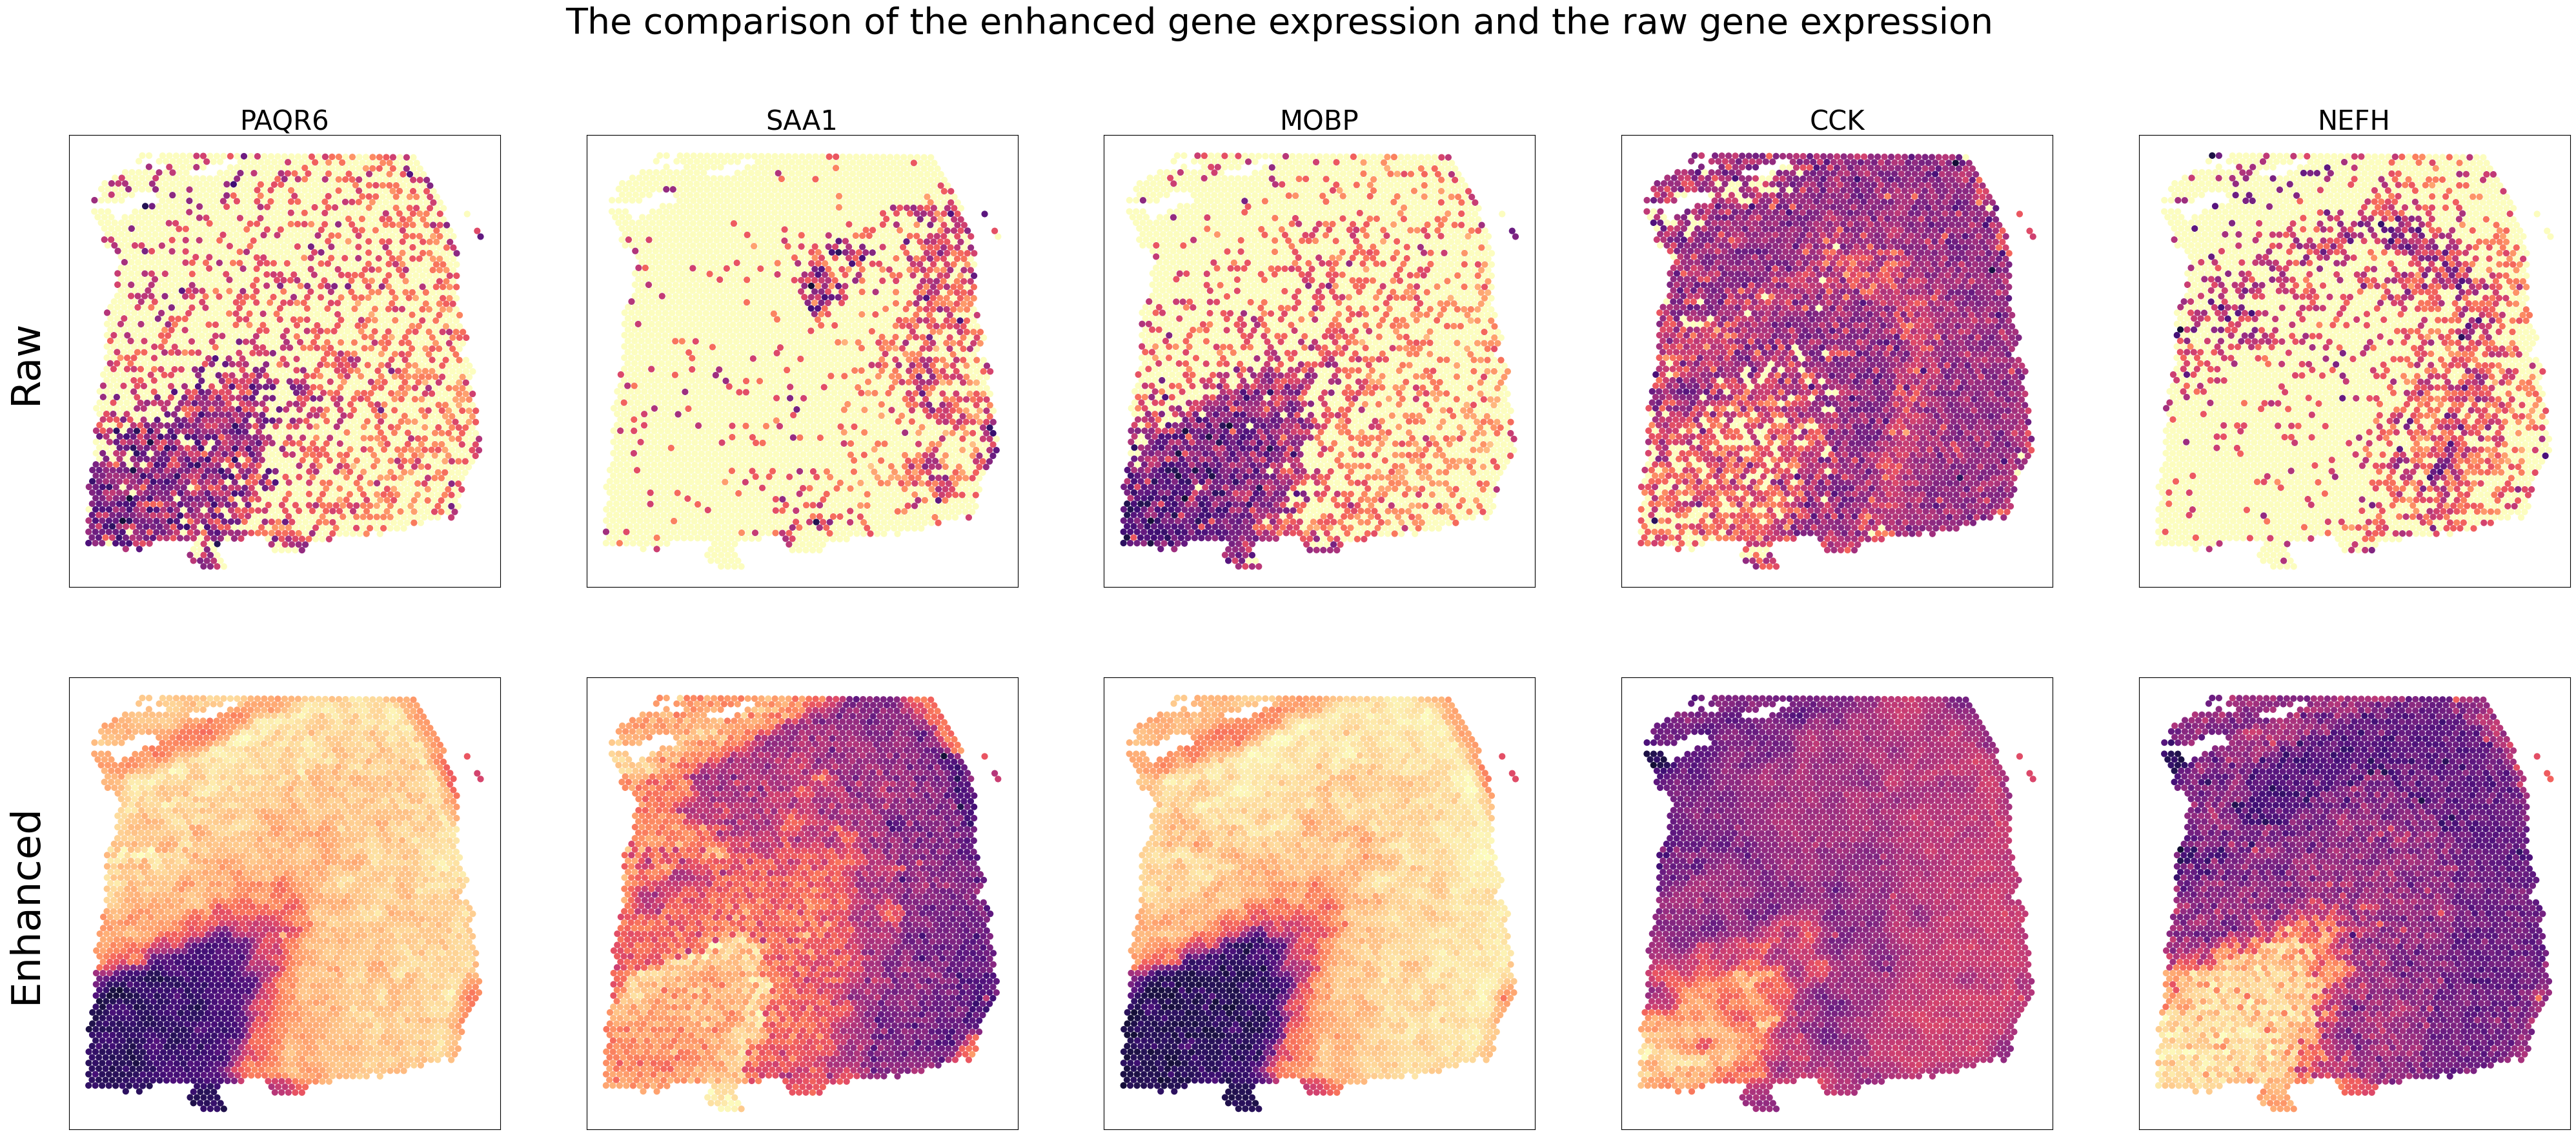

In [5]:
import matplotlib.colors as mcolors

cmap = 'magma'
gene_names = ['PAQR6', 'SAA1', 'MOBP', 'CCK', 'NEFH']

full_cmap = plt.get_cmap('magma')
start, stop = 0.1, 1.0
colors = full_cmap(np.linspace(start, stop, 256))[::-1]
ours_cmp = mcolors.LinearSegmentedColormap.from_list("RdPu_middle", colors)

loc = adata.obsm['spatial'] * np.array([1, -1])
recon_nonzero = np.where(recon<0, 0, recon)

fig, ax = plt.subplots(2, len(gene_names), figsize=(50, 20))
size = 40

for k, gene_name in enumerate(gene_names):
    idx = adata.var_names.to_list().index(gene_name)

    ax[0, k].scatter(loc[:, 0], loc[:, 1], c=adata.X[:, idx].tolist(), cmap=ours_cmp, s=size, alpha=1.0)
    ax[1, k].scatter(loc[:, 0], loc[:, 1], c=recon_nonzero[:, idx].tolist(), cmap=ours_cmp, s=size)

    ax[0, k].set_xticks([])
    ax[0, k].set_yticks([])
    
    ax[1, k].set_xticks([])
    ax[1, k].set_yticks([])
    
    ax[0, k].set_title(gene_name, fontsize=30)

ax[0, 0].text(-0.1, 0.5, 'Raw', ha='center', va='center', fontsize=45, transform=ax[0, 0].transAxes, rotation=90)
ax[0, 1].text(-0.1, 0.5, 'Enhanced', ha='center', va='center', fontsize=45, transform=ax[1, 0].transAxes, rotation=90)

fig.suptitle('The comparison of the enhanced gene expression and the raw gene expression', fontsize=40)
plt.show()

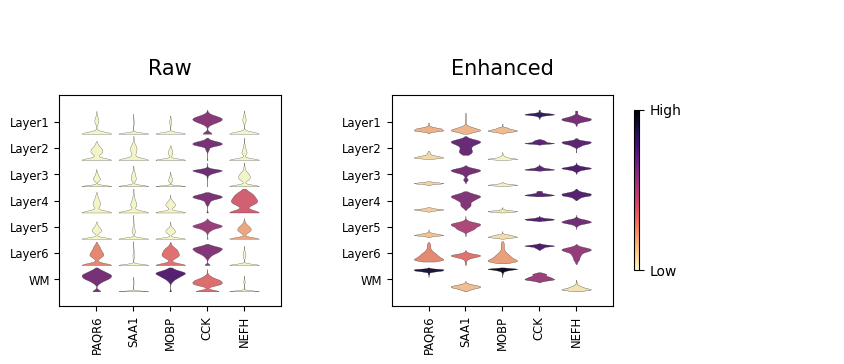

In [6]:
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors


adata.X /= adata.X.max(axis=0, keepdims=True)
adata_recon = adata.copy()
adata_recon.X = recon_nonzero / (recon_nonzero.max(axis=0, keepdims=True) + 1e-10)

cmap = mcolors.LinearSegmentedColormap.from_list("custom", plt.get_cmap('magma').colors[::-1])
norm = mcolors.Normalize(vmin=0, vmax=1)
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for i, data in enumerate([adata, adata_recon]):
    d = sc.pl.stacked_violin(data, gene_names, groupby='Ground Truth', vmax=1, ax=ax[i], show=False, cmap=cmap)
    d['color_legend_ax'].remove()
    ax[i].text(0.25, 0.8, ['Raw', 'Enhanced'][i], ha='center', va='center', fontsize=15, transform=ax[i].transAxes)


cbar = fig.colorbar(mappable, cax=fig.add_axes([0.7, 0.2, 0.005, 0.4]))
cbar.ax.tick_params(labelsize=10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Low', 'High'])

fig.subplots_adjust(top=0.85, wspace=-0.25)